In [1]:
import torch
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class CosineAnnealingWithRestartsLR(torch.optim.lr_scheduler._LRScheduler):

    r"""Set the learning rate of each parameter group using a cosine annealing
    schedule, where :math:`\eta_{max}` is set to the initial lr and
    :math:`T_{cur}` is the number of epochs since the last restart in SGDR:
    .. math::
        \eta_t = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})(1 +
        \cos(\frac{T_{cur}}{T_{max}}\pi))
    When last_epoch=-1, sets initial lr as lr.
    It has been proposed in
    `SGDR: Stochastic Gradient Descent with Warm Restarts`_. This implements
    the cosine annealing part of SGDR, the restarts and number of iterations multiplier.
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        T_max (int): Maximum number of iterations.
        T_mult (float): Multiply T_max by this number after each restart. Default: 1.
        eta_min (float): Minimum learning rate. Default: 0.
        last_epoch (int): The index of last epoch. Default: -1.
    .. _SGDR\: Stochastic Gradient Descent with Warm Restarts:
        https://arxiv.org/abs/1608.03983
    """

    def __init__(self, optimizer, T_max, eta_min=0, last_epoch=-1, T_mult=1):
        self.T_max = T_max
        self.T_mult = T_mult
        self.restart_every = T_max
        self.eta_min = eta_min
        self.restarts = 0
        self.restarted_at = 0
        super().__init__(optimizer, last_epoch)
    
    def restart(self):
        self.restart_every *= self.T_mult
        self.restarted_at = self.last_epoch
    
    def cosine(self, base_lr):
        return self.eta_min + (base_lr - self.eta_min) * (1 + math.cos(math.pi * self.step_n / self.restart_every)) / 2
    
    @property
    def step_n(self):
        return self.last_epoch - self.restarted_at

    def get_lr(self):
        if self.step_n >= self.restart_every:
            self.restart()
        return [self.cosine(base_lr) for base_lr in self.base_lrs]  

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(10, 10)
    
    def forward(self, x):
        return self.l1(x)
        

net = Net()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01)

sgdwr = CosineAnnealingWithRestartsLR(optimizer, 100, T_mult=1.5)

lrs = []
for i in range(1000):
    lr = optimizer.param_groups[0]['lr']
    sgdwr.step()
    lrs.append(lr)   

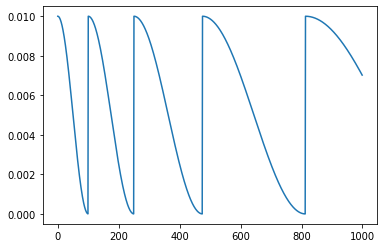

In [4]:
plt.plot(lrs)